In [18]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models

training

In [21]:
student = models.mobilenet_v3_small(weights='IMAGENET1K_V1').to('cuda')
teacher = models.mobilenet_v3_large(weights='IMAGENET1K_V1').to('cuda')

with torch.no_grad():
    # grab the original student 1024x576 weight matrix and 1024 bias
    sub_w1 = student.classifier[0].weight[:,:]
    sub_b1 = student.classifier[0].bias[:]
    new_layer1 = torch.nn.Linear(sub_w1.size()[1],1280) # 1280x576

    # use the teacher weights for the embedding to output 1000x1280
    sub_w2 = teacher.classifier[3].weight[:,:]
    sub_b2 = teacher.classifier[3].bias[:]
    new_layer2 = torch.nn.Linear(1280,1000)

    # copy pretrained part of student weight matrix to new one (fill in 1024 of 1280 rows)
    new_layer1.weight[:sub_w1.size()[0],:] = sub_w1
    new_layer1.bias[:sub_b1.size()[0]] = sub_b1

    # copyteacher weights for classification layer
    new_layer2.weight[:,:sub_w2.size()[1]] = sub_w2
    new_layer2.bias[:sub_b2.size()[0]] = sub_b2

    student.classifier[0] = new_layer1
    student.classifier[3] = new_layer2
    print(student.classifier)
    # model.classifier[0] = torch.nn.Linear(576,1280)
    # model.classifier[3] = torch.nn.Linear(1280,1000)
# model = models.mobilenet_v3_large()
# model.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
# train_loader, val_loader,_ = load_tiny_imagenet(64,1234)
# train_loader, val_loader = load_imagenet(64,12345,resize=128)
# train(model,train_loader,val_loader,'cuda',lr=0.004)

Sequential(
  (0): Linear(in_features=576, out_features=1280, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1280, out_features=1000, bias=True)
)


testing

In [35]:
test_loader = load_imagenet(128,1234,False)
test_loader128 = load_imagenet(128,1234,False,resize=128)

In [2]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_small()
model64.classifier[0] = torch.nn.Linear(576,1280)
model64.classifier[3] = torch.nn.Linear(1280,1000)
model64.load_state_dict(torch.load("best_batch_i162153.pth")['model_state_dict'])
model64 = model64.to('cuda')
model.eval()
model64.eval()

NameError: name 'models' is not defined

In [37]:
acc64_clean = validate(model64,test_loader128,'cuda')

100%|██████████| 391/391 [04:11<00:00,  1.56it/s]


In [38]:
acc64_clean

(0.57538, 1.8619217997621698, 0.80626)

In [9]:
acc_clean = validate(model,test_loader,'cuda')
acc64_clean = validate(model64,test_loader128,'cuda')

100%|██████████| 2002/2002 [02:33<00:00, 13.06it/s]


In [10]:
acc64_clean

(0.41572156700515933, 2.7379780524855963, 0.6734781488795398)

In [8]:
print("Mobilenet V3 Large Clean (224x224)\n Top 1: {:2.2f}%\t Top 5: {:2.2f}%".format(acc_clean[0]*100,acc_clean[2]*100))
print("Mobilenet V3 Large Clean (64x64)\n Top 1: {:2.2f}%\t Top 5: {:2.2f}%".format(acc64_clean[0]*100,acc64_clean[2]*100))

Mobilenet V3 Large Clean (224x224)
 Top 1: 75.31%	 Top 5: 92.63%
Mobilenet V3 Large Clean (64x64)
 Top 1: 38.34%	 Top 5: 63.53%


In [99]:
from torchprofile import profile_macs
model = model = models.mobilenet_v3_large()
input = torch.randn(1, 3, 64, 64)
profile_macs(model,input)

/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::hardswish_". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(
/home/gc28692/anaconda3/envs/cl/lib/python3.9/site-packages/torchprofile/profile.py:22: UserWarning: No handlers found: "aten::hardsigmoid". Skipped.
  warnings.warn('No handlers found: "{}". Skipped.'.format(


21781912

In [97]:
from torch.profiler import profile
model = model = models.mobilenet_v3_large()
input = torch.randn(1, 3, 224, 224)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU],
    with_flops=True
) as prof:
    outputs = model(input)

events = prof.events()
forward_flops = sum([int(evt.flops) for evt in events])
print("{:e}".format(forward_flops))
print(forward_flops/10e6)
input = torch.randn(1, 3, 64, 64)

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU],
    with_flops=True
) as prof:
    outputs = model(input)

events = prof.events()
forward_flops = sum([int(evt.flops) for evt in events])
print("{:e}".format(forward_flops))
print(forward_flops/10e6)

STAGE:2023-01-23 23:05:02 4082875:4082875 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-01-23 23:05:02 4082875:4082875 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-01-23 23:05:02 4082875:4082875 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-01-23 23:05:02 4082875:4082875 ActivityProfilerController.cpp:300] Completed Stage: Collection


4.331836e+08
43.3183576
4.274198e+07
4.2741976


In [4]:
from thop import profile
model = models.mnasnet0_5()
input = torch.randn(1, 3, 224, 224)
macs, params = profile(model, inputs=(input, ))
print("224x224:",macs/1e6,params/1e6)

# model = models.efficientnet_b0(weights='DEFAULT')
# # model.classifier[0] = torch.nn.Linear(576,1280)
# # model.classifier[3] = torch.nn.Linear(1280,1000)
# input = torch.randn(1, 3, 224, 224)
# macs, params = profile(model, inputs=(input, ))
# print("64x64:",macs/1e6,params)

# class FC(torch.nn.Module):
#     def __init__(self):
#       super(FC, self).__init__()
#       self.c = torch.nn.Linear(1280,1000)
#     def forward(self,x):
#       if len(x.shape) > 1:
#         return F.softmax(self.c(x),dim=1)
#       else:
#         return F.softmax(self.c(x),dim=0)
# fc = FC()
# input = torch.randn(1,1280)
# macs, params = profile(fc, inputs=(input, ))
# print("64x64:",macs/1e6,params)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
224x224: 116.717728 2.218512


Visualize Embeddings

In [2]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure

In [83]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

activationT = {}
activationS = {}
def get_activationT(name):
    def hook(model, input, output):
        activationT[name] = output.detach()
    return hook
def get_activationS(name):
    def hook(model, input, output):
        activationS[name] = output.detach()
    return hook

model.classifier[0].register_forward_hook(get_activationT('emb'))
model64.classifier[0].register_forward_hook(get_activationS('emb'))

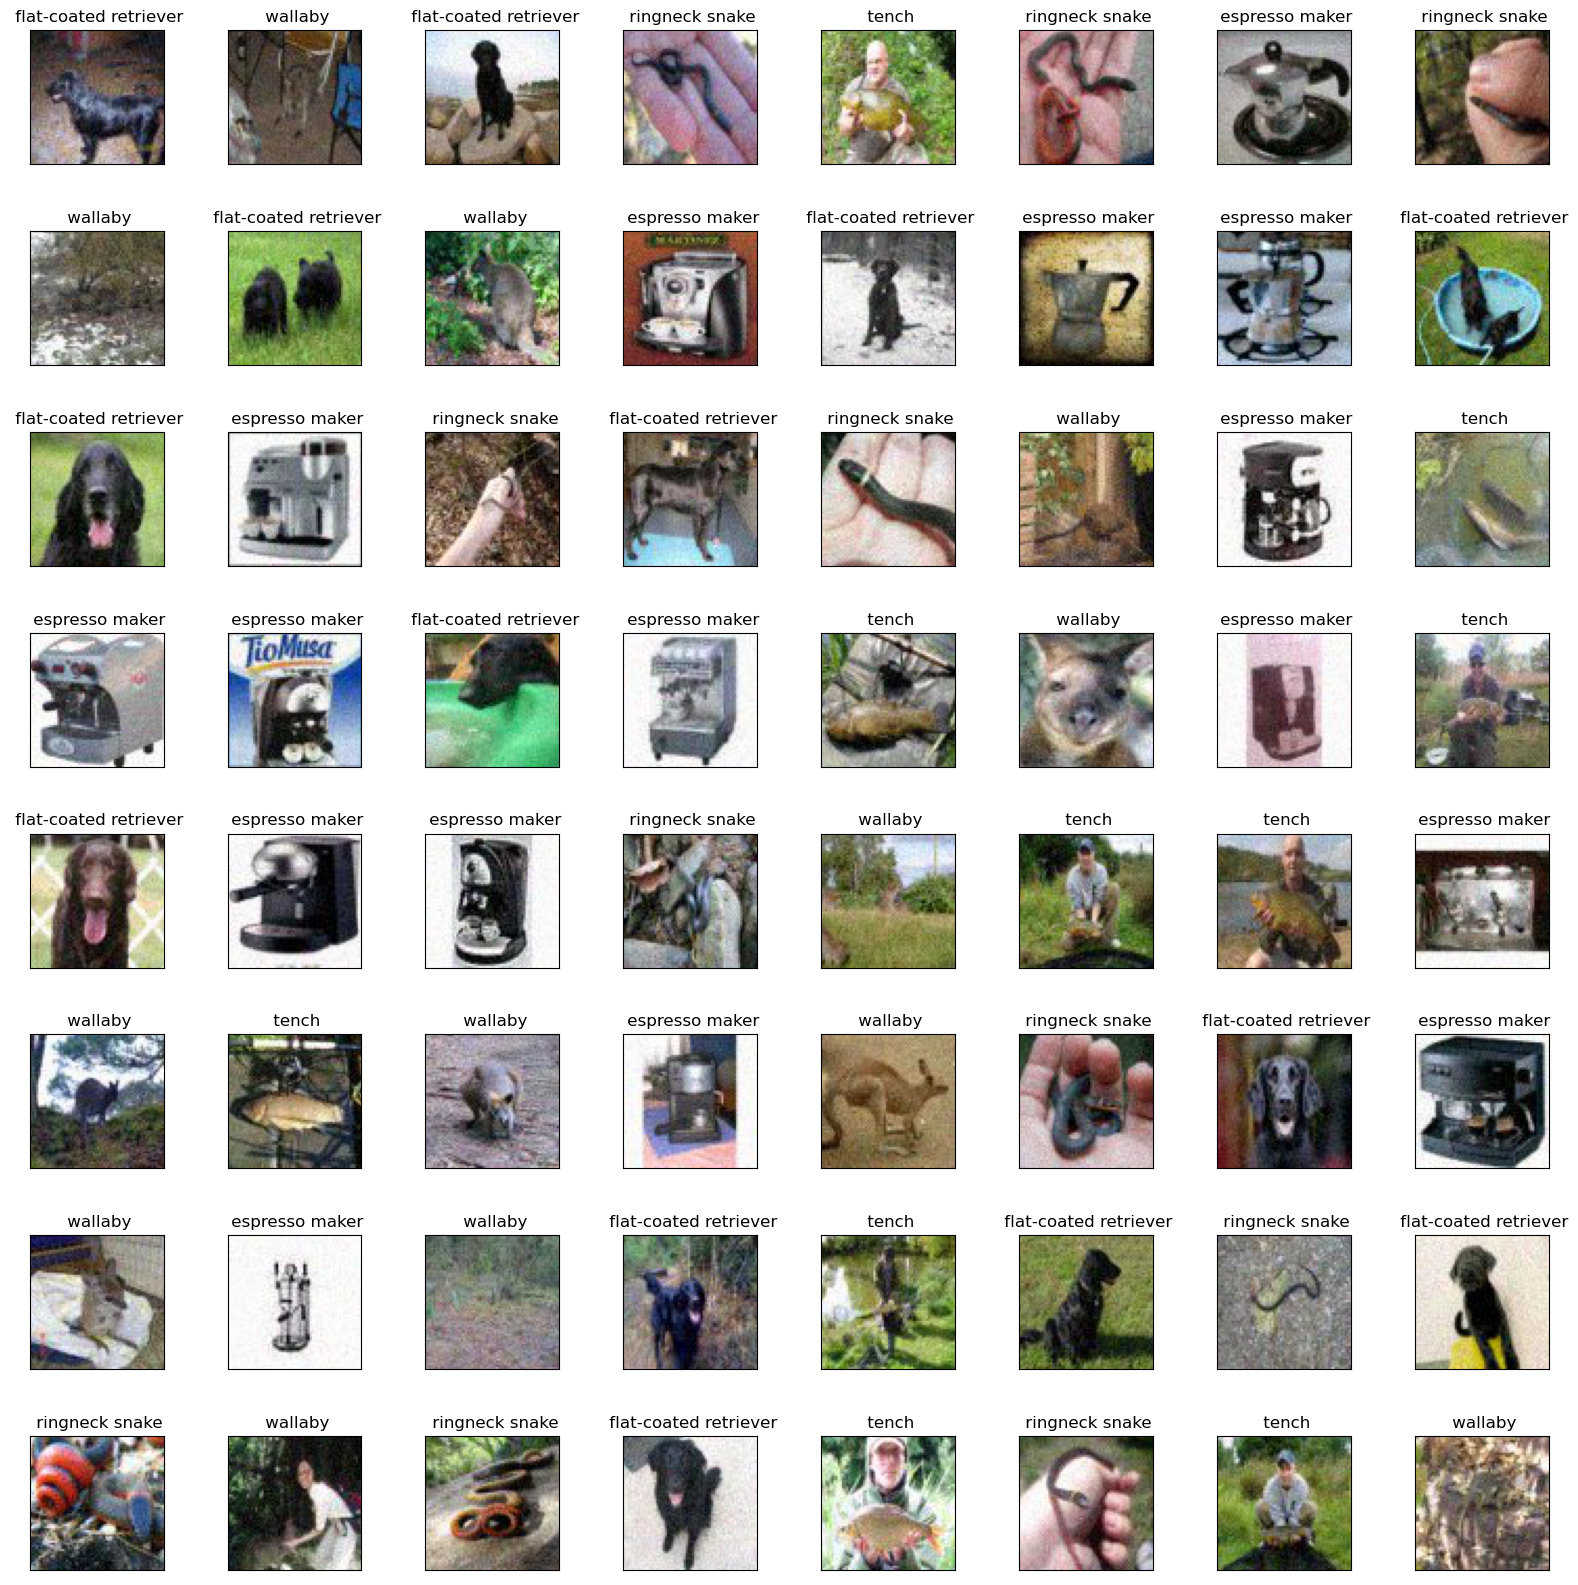

In [84]:
clean_source_loader,_ = load_imagenet(128,1234,True,[0,53,104,205,550])
clean_source_loader64,_ = load_imagenet64(128,1234,True,[0,53,104,205,550])
# visualize_batch(clean_source_loader)

corr_target_loader = load_imagenetc_val(128,1234,class_subset=[0,53,104,205,550],shuffle=True)
corr_target_loader64 = load_imagenetc64_val(128,1234,class_subset=[0,53,104,205,550],shuffle=True)
visualize_batch(corr_target_loader64)

In [4]:
# init tensorboard
writer = SummaryWriter()

batch_imgs, batch_labels = next(iter(clean_source_loader))
preds = model(batch_imgs.to('cuda'))
embds = activationT['emb'].to('cpu')

corr_batch_imgs, corr_batch_labels = next(iter(corr_target_loader))
corr_preds = model(corr_batch_imgs.to('cuda'))
corr_embds = activationT['emb'].to('cpu')

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    batch_label_strings.append(clean_source_loader.dataset.dataset.class_name_map[clean_source_loader.dataset.dataset.class_id_list[label.item()]]+"_CLEAN")

# get the labels
corr_batch_label_strings = []
for idx,label in enumerate(corr_batch_labels):
    corr_batch_label_strings.append(corr_target_loader.dataset.class_name_map[corr_target_loader.dataset.class_id_list[label.item()]]+"_CORR")

batch_imgs = torch.cat((batch_imgs,corr_batch_imgs))
batch_labels = torch.cat((batch_labels,corr_batch_labels))
batch_label_strings.extend(corr_batch_label_strings)
embds = torch.cat((embds,corr_embds))
writer.add_embedding(embds,metadata=batch_label_strings,label_img=batch_imgs)

In [85]:
# init tensorboard
writer = SummaryWriter()

batch_imgs, batch_labels = next(iter(clean_source_loader64))
preds = model64(batch_imgs.to('cuda'))
embds = activationS['emb'].to('cpu')

corr_batch_imgs, corr_batch_labels = next(iter(corr_target_loader64))
corr_preds = model64(corr_batch_imgs.to('cuda'))
corr_embds = activationS['emb'].to('cpu')

# get the labels
batch_label_strings = []
for idx,label in enumerate(batch_labels):
    batch_label_strings.append(clean_source_loader64.dataset.dataset.class_name_map[clean_source_loader64.dataset.dataset.class_id_list[label.item()]]+"_CLEAN")

# get the labels
corr_batch_label_strings = []
for idx,label in enumerate(corr_batch_labels):
    corr_batch_label_strings.append(corr_target_loader64.dataset.class_name_map[corr_target_loader64.dataset.class_id_list[label.item()]]+"_CORR")

batch_imgs = torch.cat((batch_imgs,corr_batch_imgs))
batch_labels = torch.cat((batch_labels,corr_batch_labels))
batch_label_strings.extend(corr_batch_label_strings)
embds = torch.cat((embds,corr_embds))
writer.add_embedding(embds,metadata=batch_label_strings,label_img=batch_imgs)

In [14]:
a = torch.tensor([1,1,1])
b = torch.tensor([[2,2,2],[3,3,3],[4,4,4]])
(b-a).pow(2).sum(dim=1).sqrt().argmin()

tensor(0)

## Domain Shift Direction

Get the class prototypes based on embeddings

In [31]:
batch_imgs, batch_labels = next(iter(clean_source_loader))
corr_batch_imgs, corr_batch_labels = next(iter(corr_target_loader))
cs = [0,53,104,205,550]

# compute prototype based on 15 images
clean_protos = []
corr_protos = []
for c in cs:
    # get the idxs of this class
    idxs = (batch_labels == c).nonzero()[:15].view(-1)
    # get the imgs
    imgs = batch_imgs[idxs]
    # get the embds
    preds = model(imgs.to('cuda'))
    clean_embds = activationT['emb'].to('cpu')
    clean_proto = clean_embds.mean(dim=0)
    clean_protos.append(clean_proto)

    idxs = (corr_batch_labels == c).nonzero()[:15].view(-1)
    imgs = corr_batch_imgs[idxs]
    preds = model(imgs.to('cuda'))
    corr_embds = activationT['emb'].to('cpu')
    corr_proto = corr_embds.mean(dim=0)
    corr_protos.append(corr_proto)
    

In [43]:
# shift angle between clean proto and corr proto for each class
shift_dirs = []
for i,p in enumerate(clean_protos):
    clean_proto = clean_protos[i]
    corr_proto = corr_protos[i]
    shift_dir = corr_proto - clean_proto
    shift_dir = shift_dir/torch.norm(shift_dir)
    shift_dirs.append(shift_dir)

# angle between shift dirs (expected to be zero but no, but all very similar?)
print((shift_dirs[0]@shift_dirs[0].T))
print((shift_dirs[0]@shift_dirs[1].T))
print((shift_dirs[0]@shift_dirs[2].T))
print((shift_dirs[0]@shift_dirs[3].T))
print((shift_dirs[0]@shift_dirs[4].T))
print((shift_dirs[1]@shift_dirs[2].T))
print((shift_dirs[1]@shift_dirs[3].T))
print((shift_dirs[1]@shift_dirs[4].T))
print((shift_dirs[2]@shift_dirs[3].T))
print((shift_dirs[2]@shift_dirs[4].T))
print((shift_dirs[3]@shift_dirs[4].T))
sd = corr_protos[0]-clean_protos[3]
sd = sd/torch.norm(sd)
print((shift_dirs[3]@sd.T))

tensor(1.0000)
tensor(0.2464)
tensor(0.2047)
tensor(0.1227)
tensor(0.1086)
tensor(0.1521)
tensor(0.1027)
tensor(0.1096)
tensor(0.1261)
tensor(0.1253)
tensor(0.1261)
tensor(0.3349)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


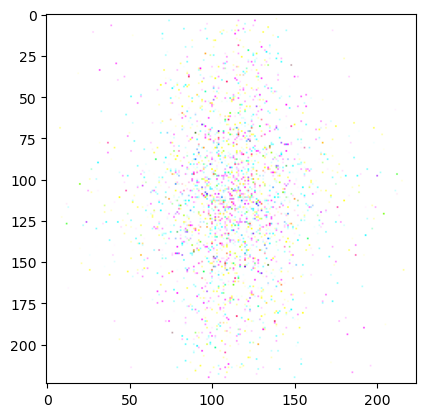

In [52]:
plt.imshow(torch.fft.fft2(clean_source_loader.dataset[0][0]).abs().permute(1,2,0))

do samples from the same class shift together

In [58]:
batch_imgs, batch_labels = next(iter(clean_source_loader64))
corr_batch_imgs, corr_batch_labels = next(iter(corr_target_loader64))
cs = [0,53,104,205,550]

# compute prototype based on 15 images
clean_protos = torch.zeros((1000,1280))
corr_protos = torch.zeros((1000,1280))
for c in cs:
    # get the idxs of this class
    idxs = (batch_labels == c).nonzero()[:15].view(-1)
    # get the imgs
    imgs = batch_imgs[idxs]
    # get the embds
    preds = model64(imgs.to('cuda'))
    clean_embds = activationS['emb'].to('cpu')
    clean_proto = clean_embds.mean(dim=0)
    clean_protos[c,:] = clean_proto

    idxs = (corr_batch_labels == c).nonzero()[:15].view(-1)
    imgs = corr_batch_imgs[idxs]
    preds = model64(imgs.to('cuda'))
    corr_embds = activationS['emb'].to('cpu')
    # print(corr_embds)
    corr_proto = corr_embds.mean(dim=0)
    corr_protos[c,:]= corr_proto

In [81]:
shift_protos = torch.zeros((1000,1280))
for c in cs:
    shift_protos[c] = corr_protos[c] - clean_protos[c]

idxs = (corr_batch_labels == 0).nonzero()[20].view(-1)
imgs = corr_batch_imgs[idxs]
preds = model64(imgs.to('cuda'))
embds = activationS['emb'].to('cpu')

t = torch.tensor([0,53,104,205,550])
(((clean_protos+shift_protos)-embds).pow(2).sum(dim=1).sqrt())[t]

tensor([23.1424, 25.6318, 24.4884, 27.8009, 28.7926])

# BASELINE FOR IMAGENET-C

In [14]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
import pandas as pd

## Load datasets

In [15]:
clean_val_loader = load_imagenet(128,1234,False)

corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

corr_val_loaders = []
corr_val_loaders64 = []
for corr in corruptions:
    corr_val_loaders.append(load_imagenetc_val(128,1234,corr,severity=1))

In [3]:
m1 = models.mobilenet_v3_small(weights='DEFAULT').eval()
m2 = models.mobilenet_v3_large(weights='DEFAULT').eval()
print(validate_ensemble([m1,m2],clean_val_loader,'cuda'))

100%|██████████| 391/391 [04:11<00:00,  1.55it/s]

(0.7503, 6.368542796815448, 0.92298)


In [17]:
ens = []
for i in range(10):
    m = models.mobilenet_v3_small()
    with torch.no_grad():
        sub_w1 = m.classifier[0].weight[:,:]
        sub_b1 = m.classifier[0].bias[:]
        new_layer1 = torch.nn.Linear(sub_w1.size()[1],1280)

        sub_w2 = m.classifier[3].weight[:,:]
        sub_b2 = m.classifier[3].bias[:]
        new_layer2 = torch.nn.Linear(1280,1000)
        m.classifier[0] = new_layer1
        m.classifier[3] = new_layer2
    m.load_state_dict(torch.load("mnv3s/mnv3s_ens"+str(i)+".pth")['model_state_dict'])
    m.to('cuda')
    ens.append(m)
df = pd.DataFrame(columns=corruptions)
validate_ensemble(ens,corr_val_loaders[3],'cuda')

100%|██████████| 391/391 [00:34<00:00, 11.20it/s]


(0.10936, 6.843762458742732, 0.26168)

## evaluate models

In [7]:
from thop import profile
model = models.mobilenet_v2()
input = torch.randn(1, 3, 224, 224)
macs, params = profile(model, inputs=(input, ))
print("224x224:",macs/1e6,params/1e6)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU6'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
224x224: 327.48672 3.504872


In [17]:
model_names = ["mobilenet_v3_small","mnasnet0_5","mnasnet0_75","mobilenet_v3_large","mobilenet_v2","resnet50"]
MACs = [52.5,116.7,234.55,234.8,327.48,4133.7]
params = [2.54,2.21,3.17,5.48,3.5,25.55]

# generate ensemble entries
for i,model_name in enumerate(model_names[:-2]):
    model_names.append([mn for mn in model_names[:i+2]])
    MACs.append(sum([mac for mac in MACs[:i+2]]))
    params.append(sum([par for par in params[:i+2]]))

df = pd.DataFrame(columns=corruptions)
df.insert(0,"Model",model_names)
df = pd.DataFrame(columns=corruptions)
df.insert(0,"Model",[str(mn) for mn in model_names])
df.insert(1,'MACs (M).',MACs)
df.insert(2,'params (M).',params)
df.insert(3,'Clean Acc.',None)
df.insert(4,'Avg Corr Acc.',None)
for model_name in model_names:
    if isinstance(model_name,list):
        torch_models = [getattr(models,mn)(weights='IMAGENET1K_V1').to('cuda') for mn in model_name]
        df.loc[df['Model']==str(model_name),'Clean Acc.'] = validate_ensemble(torch_models,clean_val_loader,'cuda')[0]
        for j,loader in enumerate(corr_val_loaders):
            df.loc[df['Model']==str(model_name),corruptions[j]] = validate_ensemble(torch_models,loader,'cuda')[0]
    else:
        model = getattr(models,model_name)(weights='IMAGENET1K_V1').to('cuda')
        df.loc[df['Model']==model_name,'Clean Acc.'] = validate(model,clean_val_loader,'cuda')[0]
        for j,loader in enumerate(corr_val_loaders):
            df.loc[df['Model']==model_name,corruptions[j]] = validate(model,loader,'cuda')[0]
df['Avg Corr Acc.'] = df.iloc[:,5:].mean(axis=1)
df.to_csv("accuracy results_ensemble_v1_sev1.csv")

100%|██████████| 391/391 [00:39<00:00,  9.88it/s]


In [2]:
for i in range(10):
    model = models.mobilenet_v3_small(weights='DEFAULT').to('cuda')
    with torch.no_grad():
        sub_w1 = model.classifier[0].weight[:,:]
        sub_b1 = model.classifier[0].bias[:]
        new_layer1 = torch.nn.Linear(sub_w1.size()[1],1280)

        sub_w2 = model.classifier[3].weight[:,:]
        sub_b2 = model.classifier[3].bias[:]
        new_layer2 = torch.nn.Linear(1280,1000)
        model.classifier[0] = new_layer1
        model.classifier[3] = new_layer2

    train_loader, val_loader = load_imagenet(64,12345)
    train(model,train_loader,val_loader,'cuda',lr=0.002,epochs=5,log_name="_ens"+str(i)+"_")


Train Epoch: 0 [0/1153050 (0%)] train loss: 6.900, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.681, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 5.926, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.536, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.297, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.201, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 3.181, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 2.996, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.917, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.587, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.574, lr: 0.00182703
Train Epoch: 0 [563200/1153050 (49%)] train loss: 2.458, lr: 0.00180876
Train Epoch: 0 [614400/1153050 (53%)] train loss: 2.243, lr: 0.00179068
Train Epoch: 0 [665600/1153050 (58%)] train loss: 2.192, lr: 0.00177277
T

100%|██████████| 2002/2002 [02:51<00:00, 11.70it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 2.294, val loss: 1.830, val acc: 0.560, top5: 0.813, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.560003746575396


Train Epoch: 1 [0/1153050 (0%)] train loss: 1.646, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.453, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 1.790, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 2.379, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.612, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 2.079, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.253, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.337, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.609, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.933, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 2.150, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.563, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 1.599, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 2.020, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:50<00:00, 11.72it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 1.312, val loss: 1.635, val acc: 0.598, top5: 0.837, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.5980705136710975


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.541, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.392, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.714, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.139, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.469, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.505, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.410, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.406, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.651, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.794, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.714, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.653, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 1.500, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.299, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:51<00:00, 11.69it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.374, val loss: 1.518, val acc: 0.624, top5: 0.852, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.6243745950966695


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.310, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.210, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.369, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.338, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.279, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 1.043, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.913, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.601, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.246, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.311, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.285, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.242, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.079, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.197, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:50<00:00, 11.72it/s]


Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.729, val loss: 1.481, val acc: 0.634, top5: 0.858, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6341234964914882
Train Epoch: 4 [0/1153050 (0%)] train loss: 1.510, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.360, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.281, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.245, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.597, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.262, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.881, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.225, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.612, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.762, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.451, lr:

100%|██████████| 2002/2002 [02:50<00:00, 11.73it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.284, val loss: 1.466, val acc: 0.638, top5: 0.860, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6376046894635372
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.909, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.725, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 5.877, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.509, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.920, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.367, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 3.035, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 3.087, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.562, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.443, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.467, lr:

100%|██████████| 2002/2002 [02:51<00:00, 11.67it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 1.921, val loss: 1.838, val acc: 0.557, top5: 0.810, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.557427975990696


Train Epoch: 1 [0/1153050 (0%)] train loss: 2.349, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 2.015, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 1.700, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 2.012, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.457, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.661, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.982, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.308, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.481, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.265, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 2.069, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.322, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 1.285, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.854, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:50<00:00, 11.75it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 2.017, val loss: 1.632, val acc: 0.601, top5: 0.839, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.6006931164482465


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.460, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.560, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.413, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.079, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.148, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.449, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.623, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.051, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.144, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.922, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.786, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.986, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 1.770, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.633, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:49<00:00, 11.83it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.685, val loss: 1.532, val acc: 0.622, top5: 0.851, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.6219471264547249


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.222, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 0.800, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.511, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.413, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.099, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 1.426, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.525, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.084, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.290, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.540, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.432, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.392, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.634, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.474, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:49<00:00, 11.84it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.182, val loss: 1.482, val acc: 0.634, top5: 0.857, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6337020067594464


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.496, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.281, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.083, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.001, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.266, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.404, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.215, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.016, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.266, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.650, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.067, lr: 0.00004715
Train Epoch: 4 [563200/1153050 (49%)] train loss: 1.570, lr: 0.00004668
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.251, lr: 0.00004622
Train Epoch: 4 [665600/1153050 (58%)] train loss: 1.469, lr: 0.00004575
T

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.329, val loss: 1.466, val acc: 0.637, top5: 0.860, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6373783338667
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.909, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.656, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 6.002, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 5.059, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.310, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.177, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 2.816, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 2.483, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.923, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.249, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.416, lr: 0.

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 2.387, val loss: 1.845, val acc: 0.558, top5: 0.810, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5580680159541669


Train Epoch: 1 [0/1153050 (0%)] train loss: 1.705, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.330, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 1.673, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 1.571, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.906, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.232, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.637, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.530, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.612, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.844, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.221, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.321, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 2.121, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.308, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:50<00:00, 11.71it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 1.021, val loss: 1.632, val acc: 0.601, top5: 0.837, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.6005135930438583


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.395, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.630, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.392, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.741, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.507, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.800, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.927, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.225, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.566, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.312, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.368, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.327, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 1.673, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.525, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:49<00:00, 11.78it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 0.969, val loss: 1.527, val acc: 0.623, top5: 0.852, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.6230086561502377


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.565, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.277, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.357, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.177, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.226, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 0.862, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.644, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.489, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.401, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.134, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.358, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.406, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.628, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.320, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:50<00:00, 11.77it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.387, val loss: 1.491, val acc: 0.631, top5: 0.856, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6312433166558692


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.113, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.270, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.671, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.554, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.433, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.633, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.317, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.873, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.249, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.258, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.181, lr: 0.00004715
Train Epoch: 4 [563200/1153050 (49%)] train loss: 1.461, lr: 0.00004668
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.331, lr: 0.00004622
Train Epoch: 4 [665600/1153050 (58%)] train loss: 1.229, lr: 0.00004575
T

100%|██████████| 2002/2002 [02:49<00:00, 11.82it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.627, val loss: 1.465, val acc: 0.638, top5: 0.860, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6382291186961918
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.921, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.755, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 5.921, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.644, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.968, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.311, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 3.144, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 2.937, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 3.127, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.752, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.090, lr:

100%|██████████| 2002/2002 [02:50<00:00, 11.75it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 2.554, val loss: 1.879, val acc: 0.551, top5: 0.804, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5506763349126189


Train Epoch: 1 [0/1153050 (0%)] train loss: 1.879, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.606, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 1.756, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 1.886, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 2.344, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.308, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.637, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.777, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.623, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.819, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.462, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.476, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 1.496, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.986, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:49<00:00, 11.81it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 1.968, val loss: 1.639, val acc: 0.599, top5: 0.836, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.5992803453093657


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.405, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.579, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.561, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.749, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.716, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.883, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.295, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.226, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.166, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.638, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.090, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.231, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 1.423, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.466, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:49<00:00, 11.81it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.984, val loss: 1.538, val acc: 0.620, top5: 0.850, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.6200894494875777


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.741, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.318, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.553, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.364, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.468, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 2.004, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.450, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.032, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.237, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.699, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.034, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 0.939, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.610, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.283, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:49<00:00, 11.80it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.789, val loss: 1.487, val acc: 0.633, top5: 0.857, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6325624234098519


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.550, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.286, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.242, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.436, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.258, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.562, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.399, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.492, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.119, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.601, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.114, lr: 0.00004715
Train Epoch: 4 [563200/1153050 (49%)] train loss: 1.487, lr: 0.00004668
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.622, lr: 0.00004622
Train Epoch: 4 [665600/1153050 (58%)] train loss: 1.210, lr: 0.00004575
T

100%|██████████| 2002/2002 [02:49<00:00, 11.80it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.204, val loss: 1.467, val acc: 0.638, top5: 0.859, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6382135079653753
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.924, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.706, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 6.028, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.582, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.925, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.145, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 2.969, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 2.970, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.352, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.799, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.292, lr:

100%|██████████| 2002/2002 [02:50<00:00, 11.74it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 1.769, val loss: 1.841, val acc: 0.557, top5: 0.812, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5565303589687551


Train Epoch: 1 [0/1153050 (0%)] train loss: 1.868, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.954, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 2.222, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 2.002, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.775, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.898, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.567, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.391, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.461, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.559, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.822, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.545, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 1.735, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.552, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:49<00:00, 11.78it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 1.160, val loss: 1.622, val acc: 0.602, top5: 0.839, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.6021527197795765


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.272, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.705, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.544, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.071, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.514, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.732, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.438, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.778, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.874, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.559, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.561, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.694, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 1.578, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.414, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:50<00:00, 11.77it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.763, val loss: 1.536, val acc: 0.623, top5: 0.850, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.622633998610645


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.277, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.006, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.357, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.585, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.200, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 1.516, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.028, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.184, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.363, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.466, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.675, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.327, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.431, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.609, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:50<00:00, 11.75it/s]


Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.547, val loss: 1.486, val acc: 0.634, top5: 0.857, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6339751945487327
Train Epoch: 4 [0/1153050 (0%)] train loss: 1.012, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.286, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.487, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.509, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.042, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.407, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.486, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.744, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.154, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.820, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.167, lr:

100%|██████████| 2002/2002 [02:50<00:00, 11.77it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.454, val loss: 1.468, val acc: 0.637, top5: 0.859, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6373939445975163
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.886, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.684, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 5.948, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.718, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.824, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.592, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 2.717, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 3.103, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.713, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.585, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.399, lr:

100%|██████████| 2002/2002 [02:49<00:00, 11.83it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 1.887, val loss: 1.849, val acc: 0.555, top5: 0.809, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5550785610028334


Train Epoch: 1 [0/1153050 (0%)] train loss: 2.045, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 2.185, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 2.149, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 1.756, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.399, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.403, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.951, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.893, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.657, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.808, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.742, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.631, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 2.049, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.485, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:50<00:00, 11.77it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 2.710, val loss: 1.634, val acc: 0.600, top5: 0.838, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.6002872374470211


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.302, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.513, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.598, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.513, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.647, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.590, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.194, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.284, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.742, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.303, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.824, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.285, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 1.651, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.656, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:50<00:00, 11.78it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.315, val loss: 1.520, val acc: 0.626, top5: 0.853, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.6257405340431013


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.402, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.350, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.201, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.258, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.090, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 1.220, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.519, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.394, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.273, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.074, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.501, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.323, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.230, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.535, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:49<00:00, 11.82it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.316, val loss: 1.482, val acc: 0.634, top5: 0.858, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6344201003769991


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.401, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.109, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.160, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.039, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.383, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.034, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.100, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.420, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.453, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.590, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.609, lr: 0.00004715
Train Epoch: 4 [563200/1153050 (49%)] train loss: 1.608, lr: 0.00004668
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.417, lr: 0.00004622
Train Epoch: 4 [665600/1153050 (58%)] train loss: 1.738, lr: 0.00004575
T

100%|██████████| 2002/2002 [02:48<00:00, 11.85it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.131, val loss: 1.467, val acc: 0.638, top5: 0.859, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6383540045427226
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.880, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.658, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 5.993, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.814, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 4.035, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.412, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 3.098, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 3.182, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.673, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.272, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.387, lr:

100%|██████████| 2002/2002 [02:49<00:00, 11.78it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 2.088, val loss: 1.839, val acc: 0.558, top5: 0.811, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5584426734937596


Train Epoch: 1 [0/1153050 (0%)] train loss: 1.754, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.703, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 1.981, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 1.355, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.704, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.896, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 2.136, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.369, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.530, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.783, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.517, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.584, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 1.692, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.516, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:49<00:00, 11.81it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 1.622, val loss: 1.626, val acc: 0.601, top5: 0.839, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.6013097403154929


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.809, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.199, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.381, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.450, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.375, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.629, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 0.942, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.358, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.363, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.556, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.679, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.604, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 2.326, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.546, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:51<00:00, 11.70it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.028, val loss: 1.523, val acc: 0.624, top5: 0.852, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.6241794609614649


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.518, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.053, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.215, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.330, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.285, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 1.222, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.535, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.530, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.268, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.614, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.140, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.427, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.676, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.693, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:49<00:00, 11.81it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.439, val loss: 1.483, val acc: 0.634, top5: 0.858, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6337098121248547


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.059, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.153, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.245, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 0.676, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.082, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.510, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.573, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.262, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.022, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.210, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.299, lr: 0.00004715
Train Epoch: 4 [563200/1153050 (49%)] train loss: 1.120, lr: 0.00004668
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.221, lr: 0.00004622
Train Epoch: 4 [665600/1153050 (58%)] train loss: 1.514, lr: 0.00004575
T

100%|██████████| 2002/2002 [02:49<00:00, 11.81it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.151, val loss: 1.466, val acc: 0.638, top5: 0.859, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6375110250786391
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.923, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.733, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 5.877, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.712, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.680, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 2.995, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 3.563, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 2.669, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.515, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.204, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.292, lr:

100%|██████████| 2002/2002 [02:49<00:00, 11.83it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 1.734, val loss: 1.810, val acc: 0.565, top5: 0.815, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5647728248397949


Train Epoch: 1 [0/1153050 (0%)] train loss: 1.856, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.777, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 1.417, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 1.964, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.736, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.546, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.653, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.763, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.389, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.583, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.849, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.906, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 2.168, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.886, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:48<00:00, 11.86it/s]


Train Epoch: 1 [468416/1153050 (100%)] train loss: 2.626, val loss: 1.658, val acc: 0.595, top5: 0.834, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.5946595689877222
Train Epoch: 2 [0/1153050 (0%)] train loss: 1.548, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.107, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.616, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.606, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.200, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.115, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.352, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.784, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.546, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.563, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.329, lr:

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.458, val loss: 1.523, val acc: 0.625, top5: 0.852, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.6250146350601403


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.206, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.493, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.025, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.481, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.083, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 1.599, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.267, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.502, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.295, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.433, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.169, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.443, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.168, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.852, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:49<00:00, 11.82it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.935, val loss: 1.479, val acc: 0.634, top5: 0.858, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6343732681845501


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.137, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.109, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.191, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.238, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.169, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.199, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.862, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.157, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.372, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.652, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 0.959, lr: 0.00004715
Train Epoch: 4 [563200/1153050 (49%)] train loss: 2.134, lr: 0.00004668
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.954, lr: 0.00004622
Train Epoch: 4 [665600/1153050 (58%)] train loss: 1.327, lr: 0.00004575
T

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.357, val loss: 1.468, val acc: 0.637, top5: 0.860, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6368163475573109
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.925, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.660, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 5.848, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.494, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.955, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.319, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 2.900, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 2.801, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.611, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.303, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.316, lr:

100%|██████████| 2002/2002 [02:50<00:00, 11.76it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 2.347, val loss: 1.829, val acc: 0.558, top5: 0.812, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5584817003208005


Train Epoch: 1 [0/1153050 (0%)] train loss: 1.613, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.899, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 1.648, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 2.417, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 1.882, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.726, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.342, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.843, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 1.969, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.719, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.722, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 2.041, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 1.353, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.620, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 1.963, val loss: 1.649, val acc: 0.598, top5: 0.835, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.5975007219963002


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.562, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.062, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.349, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.459, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.223, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.570, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.440, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.084, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.952, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.670, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.697, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.730, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 1.463, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.112, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:49<00:00, 11.82it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.551, val loss: 1.525, val acc: 0.625, top5: 0.852, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.6251941584645285


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.278, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 0.985, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.742, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.249, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.176, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 1.305, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.338, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.351, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.238, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.468, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.223, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 1.944, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.513, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.194, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:49<00:00, 11.80it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.162, val loss: 1.487, val acc: 0.634, top5: 0.857, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6338346979713856


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.441, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.025, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.666, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.112, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 1.249, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 1.505, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 1.989, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.251, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.471, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.286, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.347, lr: 0.00004715
Train Epoch: 4 [563200/1153050 (49%)] train loss: 1.287, lr: 0.00004668
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.303, lr: 0.00004622
Train Epoch: 4 [665600/1153050 (58%)] train loss: 1.533, lr: 0.00004575
T

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]


Train Epoch: 4 [468416/1153050 (100%)] train loss: 1.446, val loss: 1.469, val acc: 0.637, top5: 0.859, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.63703489778874
Train Epoch: 0 [0/1153050 (0%)] train loss: 6.940, lr: 0.00200000
Train Epoch: 0 [51200/1153050 (4%)] train loss: 6.704, lr: 0.00200000
Train Epoch: 0 [102400/1153050 (9%)] train loss: 6.132, lr: 0.00198000
Train Epoch: 0 [153600/1153050 (13%)] train loss: 4.682, lr: 0.00196020
Train Epoch: 0 [204800/1153050 (18%)] train loss: 3.822, lr: 0.00194060
Train Epoch: 0 [256000/1153050 (22%)] train loss: 3.373, lr: 0.00192119
Train Epoch: 0 [307200/1153050 (27%)] train loss: 2.924, lr: 0.00190198
Train Epoch: 0 [358400/1153050 (31%)] train loss: 3.191, lr: 0.00188296
Train Epoch: 0 [409600/1153050 (36%)] train loss: 2.364, lr: 0.00186413
Train Epoch: 0 [460800/1153050 (40%)] train loss: 2.632, lr: 0.00184549
Train Epoch: 0 [512000/1153050 (44%)] train loss: 2.273, lr: 0

100%|██████████| 2002/2002 [02:49<00:00, 11.80it/s]

Train Epoch: 0 [468416/1153050 (100%)] train loss: 2.233, val loss: 1.827, val acc: 0.559, top5: 0.812, lr: 0.00160326
==================== best validation accuracy ====================
epoch: 0, val accuracy: 0.5587548881100869


Train Epoch: 1 [0/1153050 (0%)] train loss: 1.497, lr: 0.00160326
Train Epoch: 1 [51200/1153050 (4%)] train loss: 1.710, lr: 0.00160326
Train Epoch: 1 [102400/1153050 (9%)] train loss: 2.077, lr: 0.00079361
Train Epoch: 1 [153600/1153050 (13%)] train loss: 1.637, lr: 0.00078568
Train Epoch: 1 [204800/1153050 (18%)] train loss: 2.001, lr: 0.00077782
Train Epoch: 1 [256000/1153050 (22%)] train loss: 1.567, lr: 0.00077004
Train Epoch: 1 [307200/1153050 (27%)] train loss: 1.648, lr: 0.00076234
Train Epoch: 1 [358400/1153050 (31%)] train loss: 1.749, lr: 0.00075472
Train Epoch: 1 [409600/1153050 (36%)] train loss: 2.088, lr: 0.00074717
Train Epoch: 1 [460800/1153050 (40%)] train loss: 1.682, lr: 0.00073970
Train Epoch: 1 [512000/1153050 (44%)] train loss: 1.449, lr: 0.00073230
Train Epoch: 1 [563200/1153050 (49%)] train loss: 1.587, lr: 0.00072498
Train Epoch: 1 [614400/1153050 (53%)] train loss: 1.748, lr: 0.00071773
Train Epoch: 1 [665600/1153050 (58%)] train loss: 1.886, lr: 0.00071055
T

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]

Train Epoch: 1 [468416/1153050 (100%)] train loss: 2.160, val loss: 1.636, val acc: 0.599, top5: 0.837, lr: 0.00064261
==================== best validation accuracy ====================
epoch: 1, val accuracy: 0.5988744663081402


Train Epoch: 2 [0/1153050 (0%)] train loss: 1.253, lr: 0.00064261
Train Epoch: 2 [51200/1153050 (4%)] train loss: 1.569, lr: 0.00064261
Train Epoch: 2 [102400/1153050 (9%)] train loss: 1.262, lr: 0.00031809
Train Epoch: 2 [153600/1153050 (13%)] train loss: 1.469, lr: 0.00031491
Train Epoch: 2 [204800/1153050 (18%)] train loss: 1.582, lr: 0.00031176
Train Epoch: 2 [256000/1153050 (22%)] train loss: 1.450, lr: 0.00030865
Train Epoch: 2 [307200/1153050 (27%)] train loss: 1.090, lr: 0.00030556
Train Epoch: 2 [358400/1153050 (31%)] train loss: 1.504, lr: 0.00030250
Train Epoch: 2 [409600/1153050 (36%)] train loss: 1.784, lr: 0.00029948
Train Epoch: 2 [460800/1153050 (40%)] train loss: 1.548, lr: 0.00029648
Train Epoch: 2 [512000/1153050 (44%)] train loss: 1.459, lr: 0.00029352
Train Epoch: 2 [563200/1153050 (49%)] train loss: 1.756, lr: 0.00029058
Train Epoch: 2 [614400/1153050 (53%)] train loss: 1.172, lr: 0.00028768
Train Epoch: 2 [665600/1153050 (58%)] train loss: 1.176, lr: 0.00028480
T

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]

Train Epoch: 2 [468416/1153050 (100%)] train loss: 1.065, val loss: 1.532, val acc: 0.621, top5: 0.851, lr: 0.00025757
==================== best validation accuracy ====================
epoch: 2, val accuracy: 0.621088536259825


Train Epoch: 3 [0/1153050 (0%)] train loss: 1.479, lr: 0.00025757
Train Epoch: 3 [51200/1153050 (4%)] train loss: 1.092, lr: 0.00025757
Train Epoch: 3 [102400/1153050 (9%)] train loss: 1.252, lr: 0.00012750
Train Epoch: 3 [153600/1153050 (13%)] train loss: 1.237, lr: 0.00012622
Train Epoch: 3 [204800/1153050 (18%)] train loss: 1.813, lr: 0.00012496
Train Epoch: 3 [256000/1153050 (22%)] train loss: 1.638, lr: 0.00012371
Train Epoch: 3 [307200/1153050 (27%)] train loss: 1.553, lr: 0.00012247
Train Epoch: 3 [358400/1153050 (31%)] train loss: 1.351, lr: 0.00012125
Train Epoch: 3 [409600/1153050 (36%)] train loss: 1.376, lr: 0.00012004
Train Epoch: 3 [460800/1153050 (40%)] train loss: 1.166, lr: 0.00011884
Train Epoch: 3 [512000/1153050 (44%)] train loss: 1.212, lr: 0.00011765
Train Epoch: 3 [563200/1153050 (49%)] train loss: 0.920, lr: 0.00011647
Train Epoch: 3 [614400/1153050 (53%)] train loss: 1.601, lr: 0.00011531
Train Epoch: 3 [665600/1153050 (58%)] train loss: 1.138, lr: 0.00011415
T

100%|██████████| 2002/2002 [02:50<00:00, 11.77it/s]

Train Epoch: 3 [468416/1153050 (100%)] train loss: 1.139, val loss: 1.484, val acc: 0.633, top5: 0.857, lr: 0.00010324
==================== best validation accuracy ====================
epoch: 3, val accuracy: 0.6330853828922001


Train Epoch: 4 [0/1153050 (0%)] train loss: 1.766, lr: 0.00010324
Train Epoch: 4 [51200/1153050 (4%)] train loss: 1.434, lr: 0.00010324
Train Epoch: 4 [102400/1153050 (9%)] train loss: 1.347, lr: 0.00005110
Train Epoch: 4 [153600/1153050 (13%)] train loss: 1.300, lr: 0.00005059
Train Epoch: 4 [204800/1153050 (18%)] train loss: 0.914, lr: 0.00005009
Train Epoch: 4 [256000/1153050 (22%)] train loss: 0.854, lr: 0.00004958
Train Epoch: 4 [307200/1153050 (27%)] train loss: 0.985, lr: 0.00004909
Train Epoch: 4 [358400/1153050 (31%)] train loss: 1.208, lr: 0.00004860
Train Epoch: 4 [409600/1153050 (36%)] train loss: 1.736, lr: 0.00004811
Train Epoch: 4 [460800/1153050 (40%)] train loss: 1.658, lr: 0.00004763
Train Epoch: 4 [512000/1153050 (44%)] train loss: 1.136, lr: 0.00004715
Train Epoch: 4 [563200/1153050 (49%)] train loss: 1.208, lr: 0.00004668
Train Epoch: 4 [614400/1153050 (53%)] train loss: 1.235, lr: 0.00004622
Train Epoch: 4 [665600/1153050 (58%)] train loss: 1.817, lr: 0.00004575
T

100%|██████████| 2002/2002 [02:49<00:00, 11.79it/s]

Train Epoch: 4 [468416/1153050 (100%)] train loss: 0.932, val loss: 1.467, val acc: 0.637, top5: 0.860, lr: 0.00004138
==================== best validation accuracy ====================
epoch: 4, val accuracy: 0.6373939445975163
